# 1D modified Korteweg-De Vries equation on a periodic domain

The [modified Korteweg-De Vries equation](https://en.wikipedia.org/wiki/Korteweg%E2%80%93De_Vries_equation) is a Partial Differential Equation (PDE) that describes the non-linear propagation of waves. It can model solitons and the interaction between solitions can lead to amplification, known as rogue waves.
we start with the equation in the following form:

$\frac{\partial u}{\partial t}+6*u^2 \frac{\partial u}{\partial x}+ \frac{\partial^3 u}{\partial x^3}=0$

on the domain $x \in [0, L]$ and $0 \le t \le T$. The domain is considered periodic in $x$. 

For the initial condition we will use a combination of solitons of the form:

$u(x,t=0) = a/\cosh(a(x-x_0-a^2t))$ 

For numerical discretization we follow a note by [Raslan](http://emis.muni.cz/journals/GMN/yahoo_site_admin/assets/docs/9_GMN-7112-V27N1.149222830.pdf)


In [1]:
# goto folder of this notebook (If you move this notebook then also copy the Project.toml file and run instantiate to install the packages)
cd(@__DIR__)
# load the environment
using Pkg 
Pkg.activate(".")  # activate the environment for this notebook
# load the packages
using OrdinaryDiffEq
using ComponentArrays
using Plots
using JLD2


  Activating project at `~/src_nobackup/julia_ml_tests.jl.git/model_1d`


In [2]:
# define the model

"""
    Modified Korteweg-De Vries Periodic

    A 1D mKdV equation with periodic boundary conditions.
    The state is represented vector:
    - u: velocity
"""
struct mkdv_equation
    Δx::Float64 # grid spacing
    du_dx::Vector{Float64} # temporary storage for du/dx
    d3u_dx3::Vector{Float64} # temporary storage for d2u/dx2
end

function dx!(du,u,Δx) #central du_dx for 6u^2*du/dx term
    n=length(u)
    for i=2:n-1
        du[i]=(u[i+1]-u[i-1])/(2*Δx)
    end
    #left periodic boundary condition
    du[1]=(u[2]-u[end])/(2*Δx)
    # right periodic boundary condition
    du[end]=(u[1]-u[end-1])/(2*Δx)
end

function dx3!(du,u,Δx) #central third difference for d3u/dx3 term
    n=length(u)
    for i=3:n-2
        du[i]=(-u[i-2]+2*u[i-1]-2*u[i+1]+u[i+2])/(2*Δx^3)
    end
    # at n=1
    du[1]=(-u[end-1]+2*u[end]-2*u[2]+u[3])/(2*Δx^3)
    # at n=2
    du[2]=(-u[end]+2*u[1]-2*u[3]+u[4])/(2*Δx^3)
    # at n=end-1
    du[end-1]=(-u[end-3]+2*u[end-2]-2*u[end]+u[1])/(2*Δx^3)
    # at n=end
    du[end]=(-u[end-2]+2*u[end-1]-2*u[1]+u[2])/(2*Δx^3)
end

"""
# Define the function that computes the time derivative of the state
 du/dt = -6u^2 * du/dx - * d3u/dx3
 for the mKdV equation
"""
function (f::mkdv_equation)(du_dt, u, p, t)
    Δx=f.Δx
    du_dx=f.du_dx
    dx!(du_dx,u,Δx)
    d3u_dx3=f.d3u_dx3
    dx3!(d3u_dx3,u,Δx)
    @. du_dt = -6u^2*du_dx - d3u_dx3
end

function mkdv_initial_condition(x,a::AbstractVector,x0::AbstractVector)
    result = zeros(length(x))
    for i in eachindex(a)
        result .+= a[i] .* sech.(a[i] .* (x .- x0[i]))
    end
    return result
end





mkdv_initial_condition (generic function with 1 method)

In [30]:
# setting up the problem

# parameters
nx=500     # number of spatial points
L=50.0     # length of the domain
Δx=L/nx    # spatial step
a=[2.0,-1.0]    # amplitude of the initial condition
x0=[L/4,L/2]   # initial position of the wave
p=()       # parameters (not used in this case)

# spatial grid
x=Δx*(1:nx) # spatial grid points

# initial condition
u0 = mkdv_initial_condition(x,a,x0)

# initialize model struct
f=mkdv_equation(Δx, similar(u0), similar(u0))

# time span
t_end=20.0


20.0

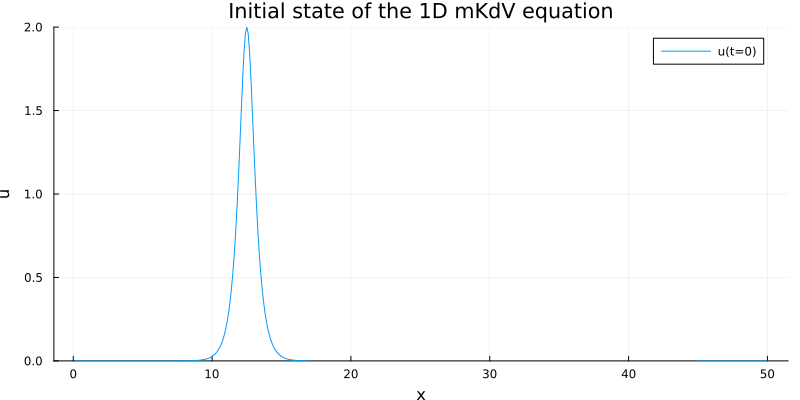

In [31]:
# plot the initial state
p1=plot(x, u0, label="u(t=0)", xlabel="x", ylabel="u")
plot(p1, size=(800,400), title="Initial state of the 1D mKdV equation",ylim=(0, 2))

In [32]:
prob = ODEProblem(f, u0, (0.0, t_end))
@time sol = solve(prob,RK4(),saveat=0.1) 

nothing

In [33]:
@show length(sol.t), sol.u[1:5]

(201, [[3.715398842451188e-11, 4.8947964745154117e-11, 6.372840776999039e-11, 8.219599462191555e-11, 1.0521068485825285e-10, 1.3382742256209088e-10, 1.6933978888443233e-10, 2.1333337011721777e-10, 2.6775099767867885e-10, 3.3497249438249363e-10  …  -6.83176598756773e-11, -6.181637496816663e-11, -5.593376911853854e-11, -5.061096723023783e-11, -4.57946969129109e-11, -4.143675531441786e-11, -3.749352669048563e-11, -3.392554588368131e-11, -3.0697103342850624e-11, -2.7775887729927945e-11], [-0.0007578316356648585, -0.00048155169978130423, 4.374831875203873e-5, 0.0005662459852008773, 0.0008318362419547239, 0.0007064451665960423, 0.00024014683922896153, -0.00035554372338175065, -0.0008063286746126245, -0.0009007442236831785  …  -0.00040133113650006803, -0.0006390507736298562, -0.0005348724319759833, -0.00013540467424220451, 0.00035173343248336516, 0.0006694484404448576, 0.0006453826703850149, 0.00028311862457303105, -0.0002388871770701296, -0.0006575000440888864], [-0.0009662577785733606, -0.0

Plots.AnimatedGif("/home/verlaan/src_nobackup/julia_ml_tests.jl.git/model_1d/mkdv1d_periodic.gif")
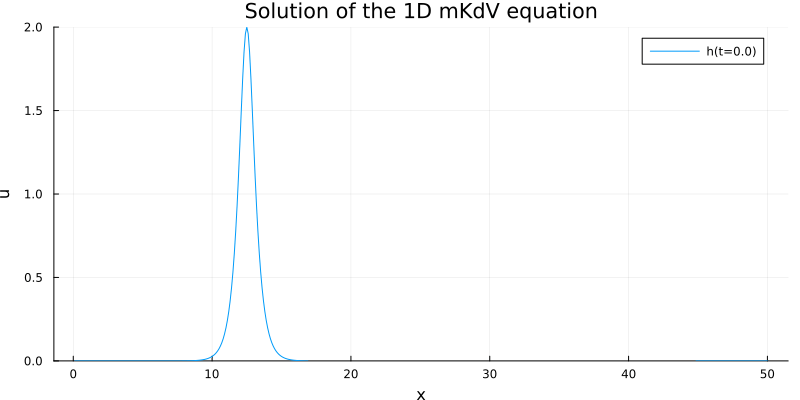

In [ ]:
# create a movie of the solution
@time begin
    # create a movie of the solution
    anim = @animate for i in 1:length(sol.t)
        p1 = plot(x, sol[i], label="h(t=$(round(sol.t[i],digits=2)))", xlabel="x", ylabel="u", ylim=(-2, 3))
        plot(p1, size=(800,400), title="Solution of the 1D mKdV equation")
    end
    gif(anim, "mkdv1d_periodic.gif", fps=15)
end


In [14]:
# save the solution to a JLD2 file
cfl_out=1.0 # CFL number for output
dt_out=cfl_out*f.Δx/u_mean # time step for output, based on CFL condition
times=collect(0.0:dt_out:t_end) # output times
solution=[]
for t in times
    push!(solution, sol(t))
end
# save the solution to a JLD2 file
save("burgers1d_periodic.jld2", 
    "solution", solution,
    "times", times,
    "params", (ν=ν, Δx=Δx, u_mean=u_mean, u_amplitude=u_amplitude, k=k),
    "grid", x,
    "cfl_out", cfl_out,
    "dt_out", dt_out,
    "description", "Solution of the 1D Burgers equation with periodic boundary conditions, using a cosine as initial condition.")


In [15]:
# load the solution from the JLD2 file for testing
ff=load("wave1d_periodic.jld2")

@show ff["solution"][1].h[1:20:end] # show some values of the initial height field

((ff["solution"])[1]).h[1:20:end] = [1.9287498479639178e-22, 1.2664165549094176e-14, 1.522997974471263e-8, 0.00033546262790251185, 0.1353352832366127, 1.0, 0.1353352832366127, 0.00033546262790251185, 1.522997974471263e-8, 1.2664165549094176e-14]


10-element Vector{Float64}:
 1.9287498479639178e-22
 1.2664165549094176e-14
 1.522997974471263e-8
 0.00033546262790251185
 0.1353352832366127
 1.0
 0.1353352832366127
 0.00033546262790251185
 1.522997974471263e-8
 1.2664165549094176e-14